In [71]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

import jax
import jax.numpy as jnp
from jax import vmap, jit, grad, vjp, jvp

In [2]:
jax.devices()

2022-04-13 10:48:57.707481: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/texinfo-6.7-el8-x86_64/lib:/software/slurm-current-el8-x86_64/lib
2022-04-13 10:48:57.707525: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


[CpuDevice(id=0)]

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [73]:
pplt.load_cmaps()

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")
sb_ids = [42, 48, 47, 53]

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [9]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4150115, 3)


In [10]:
hb_trajs = list(np.load("../../data/raw_feat/hbonds.npy", allow_pickle=True))
hb_trajs.extend(np.load("../../data/raw_feat/hbonds_anton2.npy", allow_pickle=True))
hb_arr = np.concatenate(hb_trajs)
print(hb_arr.shape)

(4150115, 18)


In [11]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

# States

In [12]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [13]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [14]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  37852
Number of up structures:   5400
Number of other structures: 4106863


In [15]:
random.seed(123)

In [16]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

# Coefficients

In [25]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [26]:
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

In [27]:
qp_coeffs = np.load("../../data/feat2_dist_du_anton2/qp_downup_3_coeffs.npy")

In [65]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)

In [21]:
d_down_arr = np.load("../../data/feat2_dist_du_anton2/dist_down_3.npy")
d_up_arr = np.load("../../data/feat2_dist_du_anton2/dist_up_3.npy")

In [22]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [23]:
def orthogonalize(basis, pi):
    numer = 0
    denom = 0
    for b, p in zip(basis, pi):
        numer += np.einsum("m,mi,mj->ij", p, b, b)
        denom += np.sum(p)
    evals, evecs = scipy.linalg.eigh(numer / denom)
    coeffs = evecs / np.sqrt(evals)[None, :]
    return coeffs

In [24]:
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
traj_lens = [len(t) for t in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

# basis_d = util.orthogonalize(basisF, weights[0])

In [24]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [25]:
guessU = np.split(guess_up, traj_inds)

In [29]:
# coeff = orthogonalize(basisF, weights[0])

In [26]:
# np.save("../../data/feat2_dist_du_anton2/basis_ortho_coeffs.npy", coeff)
coeff = np.load("../../data/feat2_dist_du_anton2/basis_ortho_coeffs.npy")

# Basis calculations

In [27]:
def min_dist(t, S):
    """Compute the minimum distance from a point in array
    t to a set S
    """
    d_S_all = jnp.linalg.norm(t[:, None, :] - S, axis=2)
    d_S = jnp.min(d_S_all, axis=1)
    return d_S

min_dist_jit  = jit(min_dist)

In [28]:
def compute_basis(arr, A=down, B=up, weights=weights, coeffs=coeff):
    """Compute the value of the basis functions at a given point arr
    """
    # compute distance to domain
    d_A = min_dist(arr, A)
    d_B = min_dist(arr, B)

    # smooth
    smooth = (d_A * d_B) ** 0.5 / (d_A + d_B)
    b = arr * smooth[:, None]
    
    # orthogonalize
    return b @ coeffs

basis_jit = jit(compute_basis)

## VJP

In [29]:
xs = sb_arr[:500]
v = qp_coeffs[0]
b, vjp_fun = jax.vjp(compute_basis, xs)
# jitted_vjp_fun = jit(vjp_fun)
grad_b = vjp_fun(jnp.tile(v, len(xs)).T)
# grad_b = jitted_vjp_fun(np.tile(v, len(xs)).T)

In [31]:
grad_b[0].shape

(500, 60)

In [ ]:
def chunk_inds(total_len: int, chunk_len: int):
    indices = []
    curr = chunk_len
    while curr < total_len:
        indices.append(curr)
        curr += chunk_len
    return indices

In [42]:
split_500 = chunk_inds(len(cv_arr), 500)

In [48]:
split_sb = np.split(sb_arr, split_500)

In [50]:
len(split_sb), split_sb[-1].shape

(8301, (115, 60))

In [51]:
basis_all = []
grad_all = []
for chunk in split_sb:
    b, vjp_fun = jax.vjp(compute_basis, chunk)
    basis_all.append(b)
    grad_b = vjp_fun(jnp.tile(v, len(chunk)).T)
    grad_all.append(grad_b)

In [56]:
grad_all = np.concatenate([np.squeeze(g) for g in grad_all])

In [57]:
grad_all.shape

(4150115, 60)

In [58]:
np.save("../../data/feat2_dist_du_anton2/qp_grad_lag1.npy", grad_all)

## Guess

In [76]:
def guess(point: np.ndarray, A=down, B=up):
    # d_A = min_dist(arr, A)
    # d_B = min_dist(arr, B)
    d_A_all = jnp.linalg.norm(point[None, None, :] - A, axis=2)
    d_A = jnp.min(d_A_all)
    d_B_all = jnp.linalg.norm(point[None, None, :] - B, axis=2)
    d_B = jnp.min(d_B_all)
    
    return (d_A**2) / (d_A**2 + d_B**2)

guess_jit = jit(guess)

In [ ]:
grad_guess = grad(guess)
grad_guess(sb_arr[0])

In [40]:
batch_jit_grad_guess = jit(vmap(grad_guess), backend='cpu')

In [52]:
xs = sb_trajs[0]
# xs = sb_arr
grad_guess = []
for traj in sb_trajs:
    grad_guess = batch_jit_grad_guess(traj)

RuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 39137692708428 bytes.

In [77]:
split_big = chunk_inds(len(cv_arr), 10000)
split_sb = np.split(sb_arr, split_big)
len(split_sb), split_sb[-1].shape

(416, (115, 60))

In [78]:
grad_guess_all = []
for chunk in split_sb:
    grad_guess = batch_jit_grad_guess(chunk)
    grad_guess_all.append(grad_guess)

In [79]:
grad_guess_all[0].shape

(10000, 60)

In [80]:
grad_guess_all = np.concatenate(grad_guess_all)

In [81]:
grad_guess_all.shape

(4150115, 60)

In [82]:
np.save("../../data/feat2_dist_du_anton2/qp_grad_guess_lag1.npy", grad_guess_all)

# Plot

In [17]:
grad_all = np.load("../../data/feat2_dist_du_anton2/qp_grad_lag1.npy")
grad_guess_all = np.load("../../data/feat2_dist_du_anton2/qp_grad_guess_lag1.npy")

In [18]:
q_grad = grad_all + grad_guess_all

In [19]:
q_grad.shape

(4150115, 60)

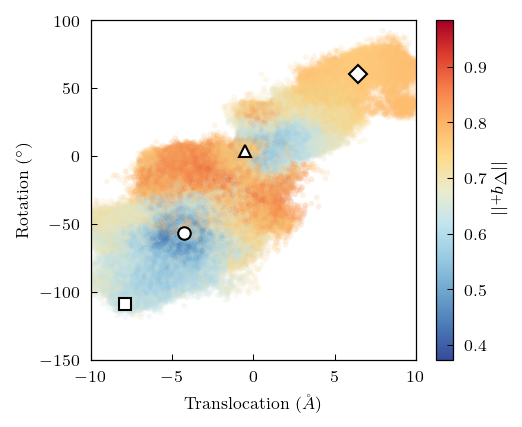

In [22]:
f = plt.figure(figsize=(3.5, 3))
ax = f.gca()
plt.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=np.linalg.norm(q_grad, axis=1)[inds], cmap=cm_div, alpha=0.1)
cb = plt.colorbar()
cb.solids.set(alpha=1)
cb.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, ms=6)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


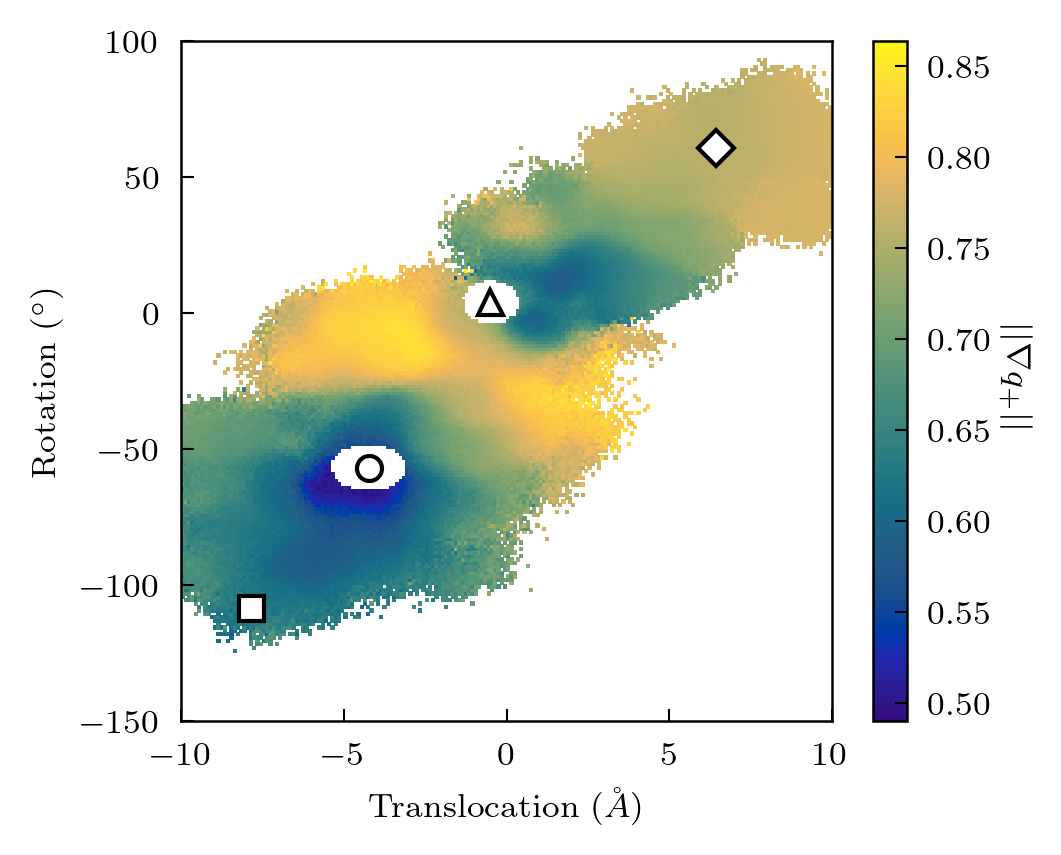

In [74]:
xe, ye = np.linspace(-10, 10, 201), np.linspace(-150, 100, 201)
traj_inds = util.split_indices(cv_trajs)
norm = np.split(np.linalg.norm(q_grad, axis=1), traj_inds)
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
hist = extq.projection.average2d(dist_trajs, rot_trajs, norm, weights[0], xe, ye)

f = plt.figure(figsize=(3.5, 3), dpi=300)
ax = f.gca()
pc = ax.pcolor(xe, ye, hist.T, cmap='macaw')
cb = plt.colorbar(pc, ax=ax)
cb.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, ms=6)

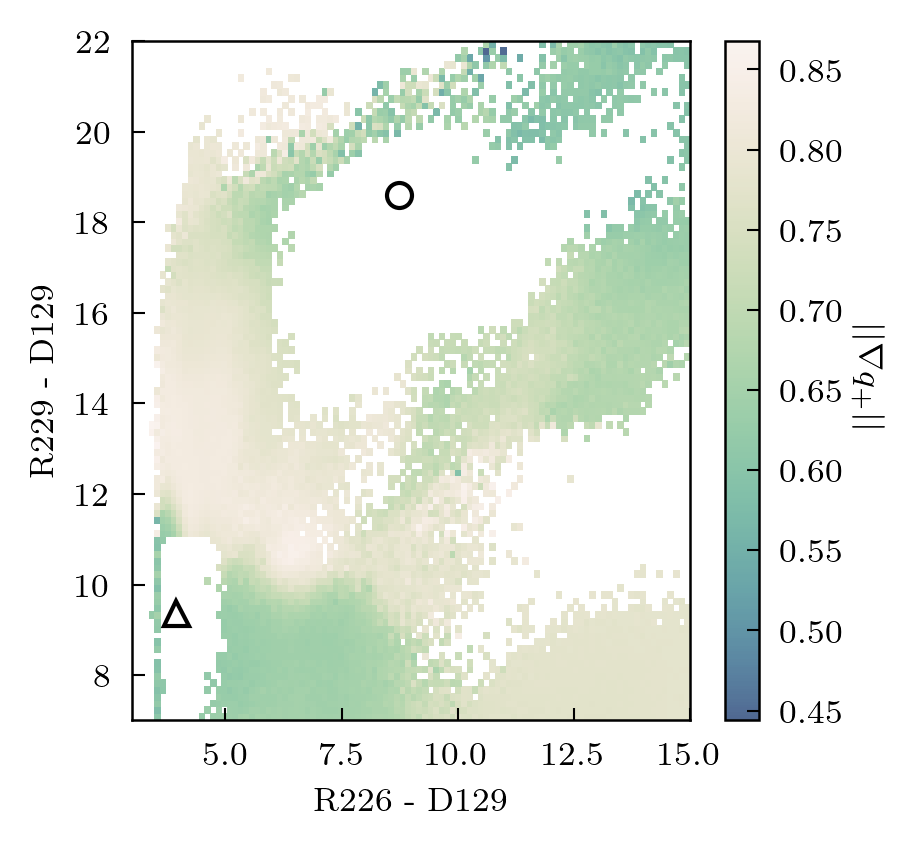

In [87]:
xe, ye = np.linspace(3, 15, 101), np.linspace(7, 22, 101)
norm = np.split(np.linalg.norm(q_grad, axis=1), traj_inds)
sb1, sb2 = sb_ids[0], sb_ids[1]
sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
sb2_trajs = [t[:, sb2] * 10 for t in sb_trajs]
hist = extq.projection.average2d(sb1_trajs, sb2_trajs, norm, weights[0], xe, ye)

f = plt.figure(figsize=(3, 3), dpi=300)
ax = f.gca()
pc = ax.pcolor(xe, ye, hist.T, cmap=cm_seq)
cb = plt.colorbar(pc, ax=ax)
cb.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
ax.set_xlabel(util.sb_label(sb1))
ax.set_ylabel(util.sb_label(sb2))
ax.set_xlim([3, 15])
ax.set_ylim([7, 22])
plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

In [31]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.01, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors_black)

/scratch/local/jobs/3850877/ipykernel_792569/3403050208.py:11: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy
/scratch/local/jobs/3850877/ipykernel_792569/3403050208.py:61: RuntimeWarning: invalid value encountered in true_divide
  (grad_x / col).T,
/scratch/local/jobs/3850877/ipykernel_792569/3403050208.py:62: RuntimeWarning: invalid value encountered in true_divide
  (grad_y / col).T,


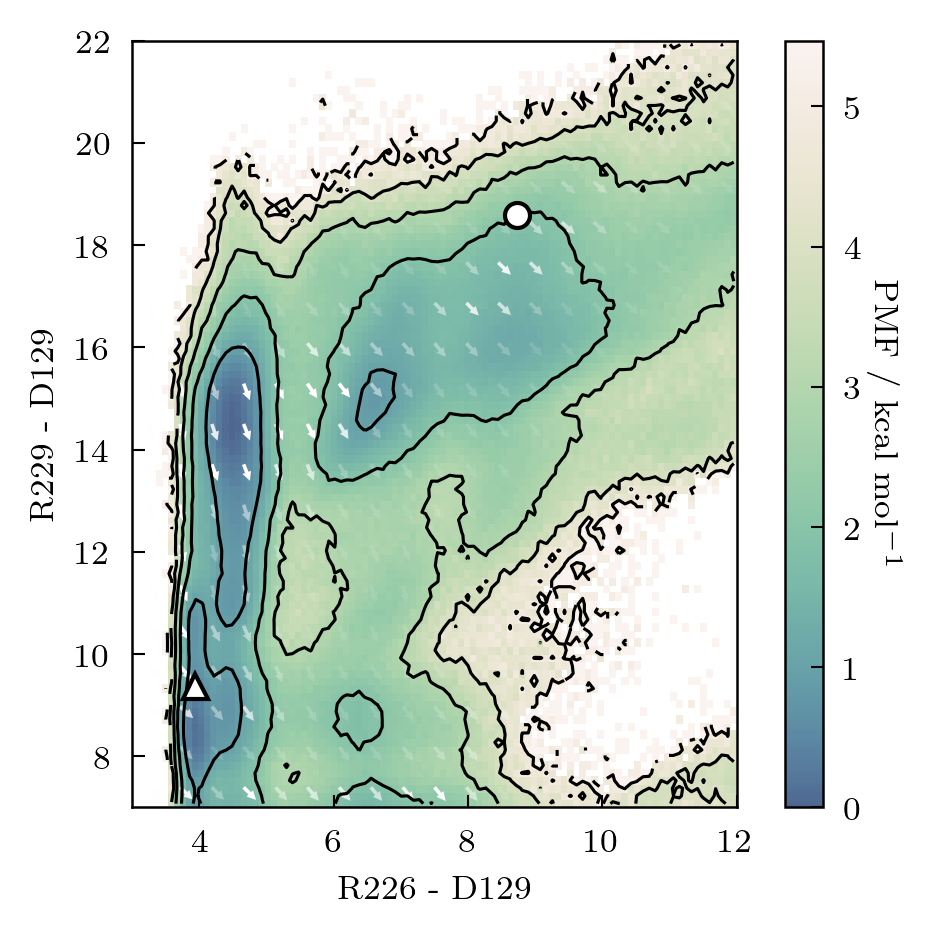

In [62]:
sb0, sb1 = sb_ids[0], sb_ids[1]
xmin, xmax, ymin, ymax = 3, 12, 7, 22

# PMF for contours
xlim = np.linspace(xmin, xmax, 101)
ylim = np.linspace(ymin, ymax, 101)
sb0_trajs = [t[:, sb0] * 10 for t in sb_trajs]
sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights[0], xlim, ylim)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2
clines = np.linspace(0, 10, 11)

# hist = extq.projection.average2d(sb1_trajs, sb2_trajs, norm, weights[0], xe, ye)
n = 19
xlim_flux = np.linspace(xmin, xmax, n + 1)
ylim_flux = np.linspace(ymin, ymax, n + 1)
centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2

X, Y = np.meshgrid(centerx_flux, centery_flux)
# grad_x, _, _ = util.kdesum2d(
#     sb_arr[:, sb0] * 10,
#     sb_arr[:, sb1] * 10,
#     np.nan_to_num(q_grad[:, sb0]),
#     nx=n,
#     ny=n,
#     xmin=xmin,
#     xmax=xmax,
#     ymin=ymin,
#     ymax=ymax,
# )
# grad_y, _, _ = util.kdesum2d(
#     sb_arr[:, sb0] * 10,
#     sb_arr[:, sb1] * 10,
#     np.nan_to_num(q_grad[:, sb1]),
#     nx=n,
#     ny=n,
#     xmin=xmin,
#     xmax=xmax,
#     ymin=ymin,
#     ymax=ymax,
# )
grad_x, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb0]))
grad_y, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb1]))

# plotting
f = plt.figure(figsize=(3, 3), dpi=300, constrained_layout=True)
ax = f.gca()

ax, h = plotting.plot_pmf(
        ax, pmf, xlim , ylim, units="kcal", clines=clines, cmap=cm_seq
)
# ax.contour(centerx, centery, diff.T, levels=clines, colors='black')
col = (grad_x ** 2 + grad_y ** 2) ** 0.5
quiv = ax.quiver(
    X,
    Y,
    (grad_x / col).T,
    (grad_y / col).T,
    col.T,
    width=0.006,
    cmap=cmapwhite,
    headwidth=2.5,
    headlength=2.5,
    headaxislength=2.5,
    clim=(0, 5e3)
)

# cb2 = plt.colorbar(quiv, ax=ax)
# cb2.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
cb = plt.colorbar(h, ax=ax)
cb.set_label("PMF / kcal mol$^{-1}$", rotation=-90, labelpad=10)

ax.set_xlabel(util.sb_label(sb0))
ax.set_ylabel(util.sb_label(sb1))
ax.set_xlim([3, 12])
ax.set_ylim([7, 22])
plotting.plot_models(ax, sb_models[:, [sb0, sb1]] * 10, ms=6)

/scratch/local/jobs/3850877/ipykernel_792569/3344006470.py:31: RuntimeWarning: invalid value encountered in true_divide
  (grad_x / col).T,
/scratch/local/jobs/3850877/ipykernel_792569/3344006470.py:32: RuntimeWarning: invalid value encountered in true_divide
  (grad_y / col).T,


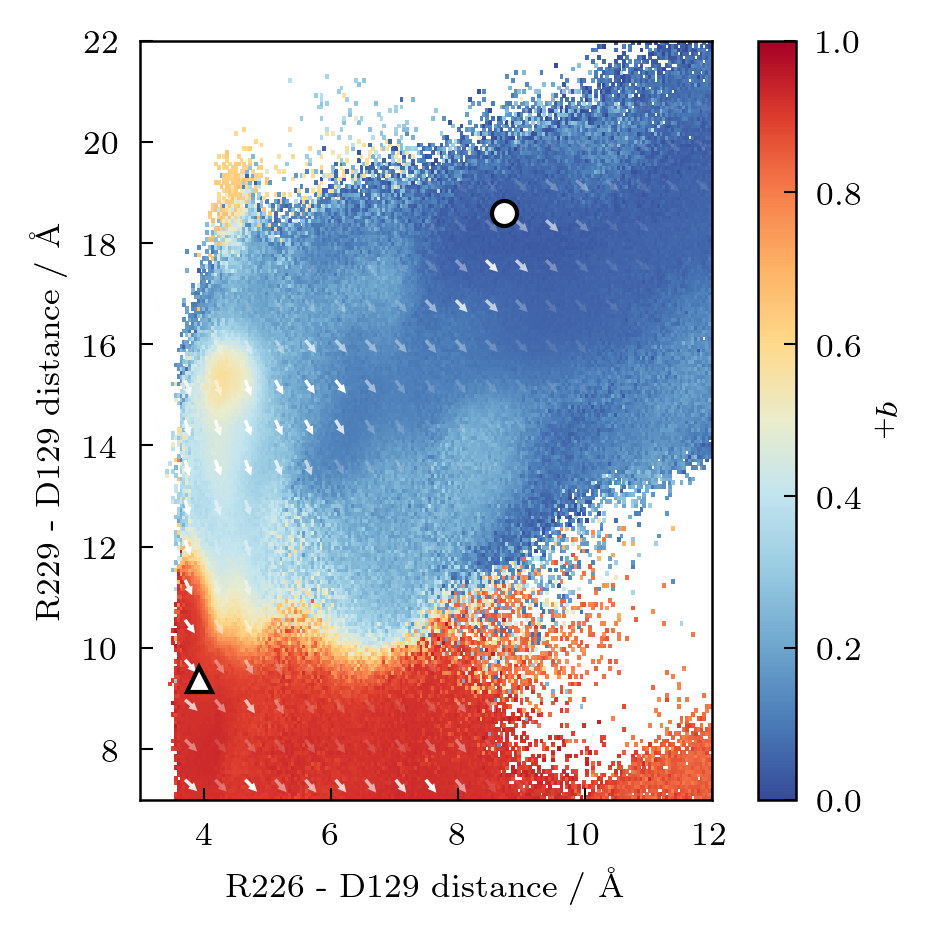

In [68]:
sb0, sb1 = sb_ids[0], sb_ids[1]
xmin, xmax, ymin, ymax = 3, 12, 7, 22

# hist = extq.projection.average2d(sb1_trajs, sb2_trajs, norm, weights[0], xe, ye)
n = 19
xlim_flux = np.linspace(xmin, xmax, n + 1)
ylim_flux = np.linspace(ymin, ymax, n + 1)
centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2

X, Y = np.meshgrid(centerx_flux, centery_flux)
grad_x, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb0]))
grad_y, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb1]))

# plotting
f = plt.figure(figsize=(3, 3), dpi=300, constrained_layout=True)
ax = f.gca()

sb0_trajs = [t[:, sb0] * 10 for t in sb_trajs]
sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
xlim = np.linspace(xmin, xmax, 201)
ylim = np.linspace(ymin, ymax, 201)
q_dens = extq.projection.average2d(
    sb0_trajs, sb1_trajs, q[8], weights[0], xlim, ylim
)
h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
col = (grad_x ** 2 + grad_y ** 2) ** 0.5
quiv = ax.quiver(
    X,
    Y,
    (grad_x / col).T,
    (grad_y / col).T,
    col.T,
    width=0.006,
    cmap=cmapwhite,
    headwidth=2.5,
    headlength=2.5,
    headaxislength=2.5,
    clim=(0, 5e3)
)

# cb2 = plt.colorbar(quiv, ax=ax)
# cb2.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)

ax.set_xlabel(f"{util.sb_label(sb0)} distance / Å")
ax.set_ylabel(f"{util.sb_label(sb1)} distance / Å")
ax.set_xlim([3, 12])
ax.set_ylim([7, 22])
plotting.plot_models(ax, sb_models[:, [sb0, sb1]] * 10, ms=6)

/scratch/local/jobs/3850877/ipykernel_792569/3493206337.py:11: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy
/scratch/local/jobs/3850877/ipykernel_792569/3493206337.py:61: RuntimeWarning: invalid value encountered in true_divide
  (grad_x / col).T,
/scratch/local/jobs/3850877/ipykernel_792569/3493206337.py:62: RuntimeWarning: invalid value encountered in true_divide
  (grad_y / col).T,


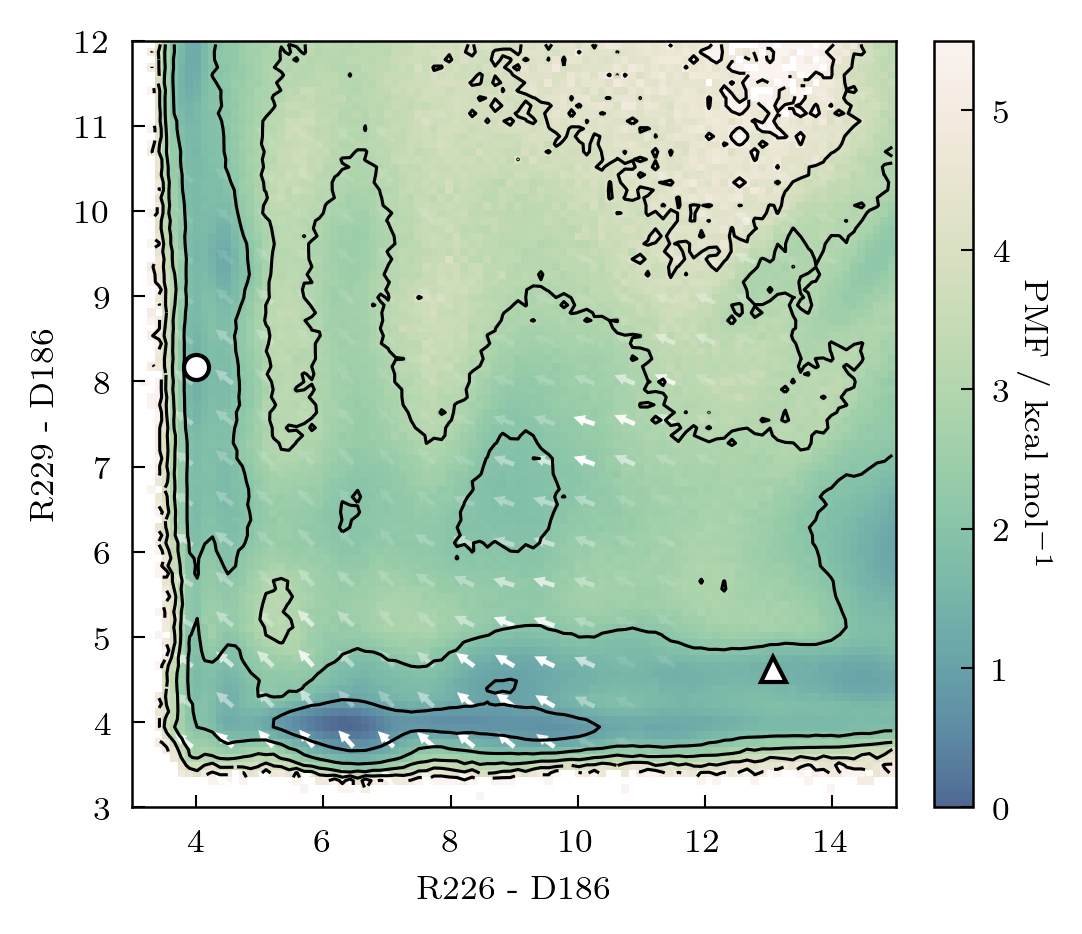

In [63]:
sb0, sb1 = sb_ids[2], sb_ids[3]
xmin, xmax, ymin, ymax = 3, 15, 3, 12

# PMF for contours
xlim = np.linspace(xmin, xmax, 101)
ylim = np.linspace(ymin, ymax, 101)
sb0_trajs = [t[:, sb0] * 10 for t in sb_trajs]
sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights[0], xlim, ylim)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2
clines = np.linspace(0, 10, 11)

# hist = extq.projection.average2d(sb1_trajs, sb2_trajs, norm, weights[0], xe, ye)
n = 19
xlim_flux = np.linspace(xmin, xmax, n + 1)
ylim_flux = np.linspace(ymin, ymax, n + 1)
centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2

X, Y = np.meshgrid(centerx_flux, centery_flux)
# grad_x, _, _ = util.kdesum2d(
#     sb_arr[:, sb0] * 10,
#     sb_arr[:, sb1] * 10,
#     np.nan_to_num(q_grad[:, sb0]),
#     nx=n,
#     ny=n,
#     xmin=xmin,
#     xmax=xmax,
#     ymin=ymin,
#     ymax=ymax,
# )
# grad_y, _, _ = util.kdesum2d(
#     sb_arr[:, sb0] * 10,
#     sb_arr[:, sb1] * 10,
#     np.nan_to_num(q_grad[:, sb1]),
#     nx=n,
#     ny=n,
#     xmin=xmin,
#     xmax=xmax,
#     ymin=ymin,
#     ymax=ymax,
# )
grad_x, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb0]))
grad_y, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb1]))

# plotting
f = plt.figure(figsize=(3.5, 3), dpi=300, constrained_layout=True)
ax = f.gca()

ax, h = plotting.plot_pmf(
        ax, pmf, xlim , ylim, units="kcal", clines=clines, cmap=cm_seq
)
# ax.contour(centerx, centery, diff.T, levels=clines, colors='black')
col = (grad_x ** 2 + grad_y ** 2) ** 0.5
quiv = ax.quiver(
    X,
    Y,
    (grad_x / col).T,
    (grad_y / col).T,
    col.T,
    width=0.006,
    cmap=cmapwhite,
    headwidth=2.5,
    headlength=2.5,
    headaxislength=2.5,
    clim=(0, 5e3)
)

# cb2 = plt.colorbar(quiv, ax=ax)
# cb2.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
cb = plt.colorbar(h, ax=ax)
cb.set_label("PMF / kcal mol$^{-1}$", rotation=-90, labelpad=10)

ax.set_xlabel(util.sb_label(sb0))
ax.set_ylabel(util.sb_label(sb1))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plotting.plot_models(ax, sb_models[:, [sb0, sb1]] * 10, ms=6)

/scratch/local/jobs/3850877/ipykernel_792569/1749238133.py:11: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy
/project/dinner/scguo/ci-vsd/notebooks/anton2/../../python/plotting.py:125: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy
/scratch/local/jobs/3850877/ipykernel_792569/1749238133.py:38: RuntimeWarning: invalid value encountered in true_divide
  (grad_x / col).T,
/scratch/local/jobs/3850877/ipykernel_792569/1749238133.py:39: RuntimeWarning: invalid value encountered in true_divide
  (grad_y / col).T,


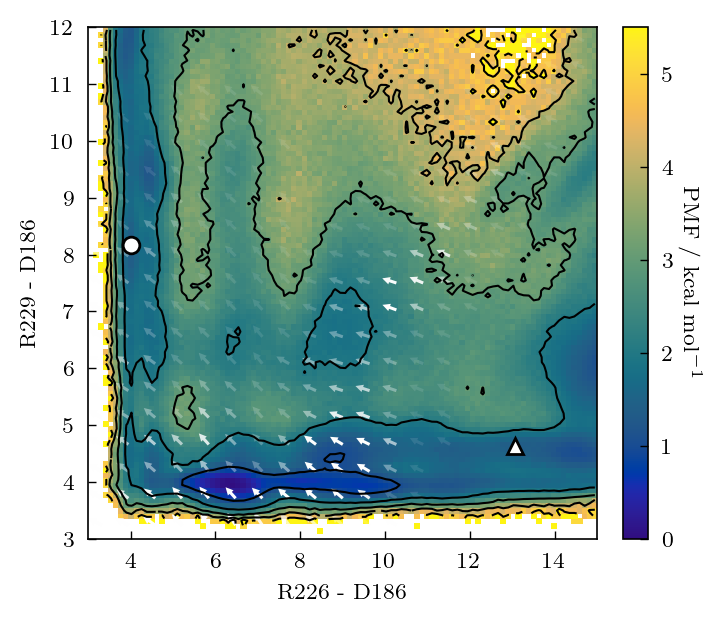

In [77]:
sb0, sb1 = sb_ids[2], sb_ids[3]
xmin, xmax, ymin, ymax = 3, 15, 3, 12

# PMF for contours
xlim = np.linspace(xmin, xmax, 101)
ylim = np.linspace(ymin, ymax, 101)
sb0_trajs = [t[:, sb0] * 10 for t in sb_trajs]
sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights[0], xlim, ylim)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2
clines = np.linspace(0, 10, 11)

n = 19
xlim_flux = np.linspace(xmin, xmax, n + 1)
ylim_flux = np.linspace(ymin, ymax, n + 1)
centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2

X, Y = np.meshgrid(centerx_flux, centery_flux)
grad_x, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb0]))
grad_y, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb1]))

# plotting
f = plt.figure(figsize=(3.5, 3), dpi=200, constrained_layout=True)
ax = f.gca()

ax, h = plotting.plot_pmf(
        ax, pmf, xlim , ylim, units="kcal", clines=clines, cmap='macaw'
)
# ax.contour(centerx, centery, diff.T, levels=clines, colors='black')
col = (grad_x ** 2 + grad_y ** 2) ** 0.5
quiv = ax.quiver(
    X,
    Y,
    (grad_x / col).T,
    (grad_y / col).T,
    col.T,
    width=0.006,
    cmap=cmapwhite,
    headwidth=2.5,
    headlength=2.5,
    headaxislength=2.5,
    clim=(0, 5e3)
)

# cb2 = plt.colorbar(quiv, ax=ax)
# cb2.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
cb = plt.colorbar(h, ax=ax)
cb.set_label("PMF / kcal mol$^{-1}$", rotation=-90, labelpad=10)

ax.set_xlabel(util.sb_label(sb0))
ax.set_ylabel(util.sb_label(sb1))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plotting.plot_models(ax, sb_models[:, [sb0, sb1]] * 10, ms=6)

/scratch/local/jobs/3850877/ipykernel_792569/3988746872.py:34: RuntimeWarning: invalid value encountered in true_divide
  (grad_x / col).T,
/scratch/local/jobs/3850877/ipykernel_792569/3988746872.py:35: RuntimeWarning: invalid value encountered in true_divide
  (grad_y / col).T,


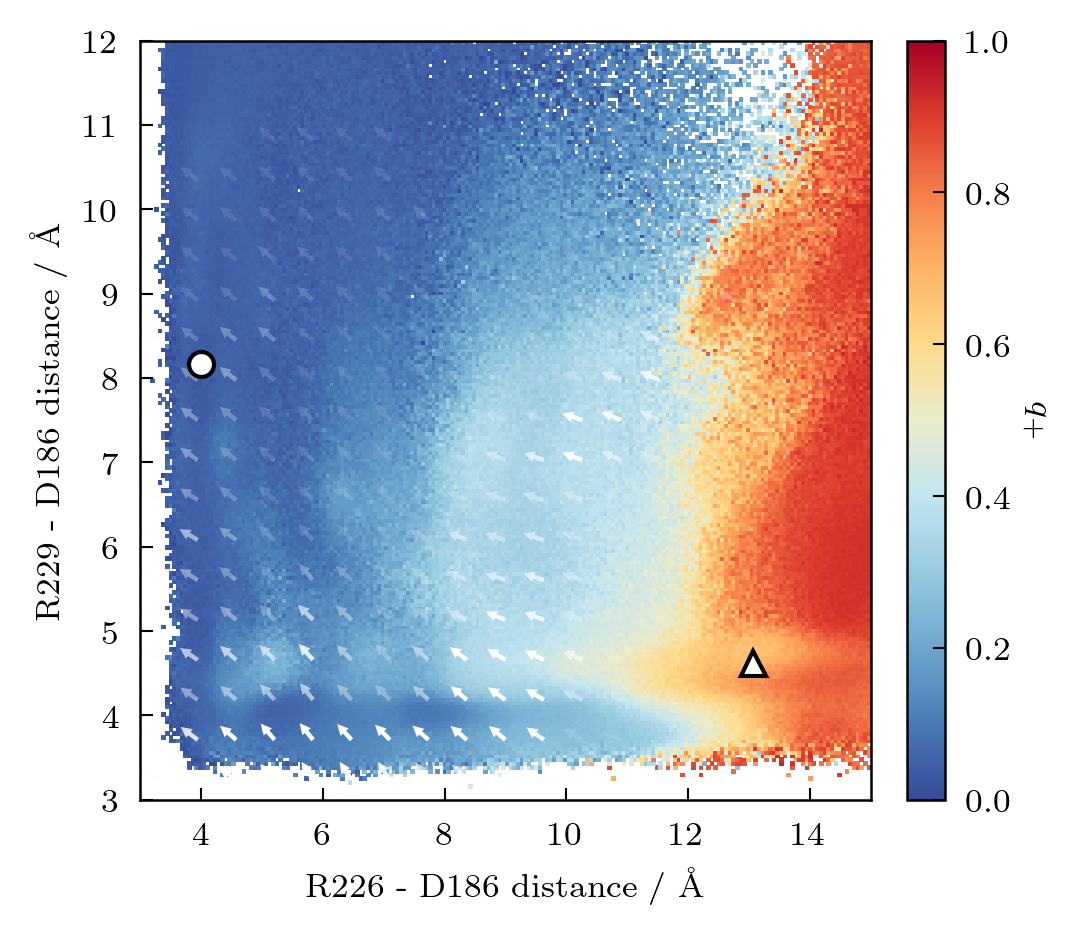

In [70]:
sb0, sb1 = sb_ids[2], sb_ids[3]
xmin, xmax, ymin, ymax = 3, 15, 3, 12


# hist = extq.projection.average2d(sb1_trajs, sb2_trajs, norm, weights[0], xe, ye)
n = 19
xlim_flux = np.linspace(xmin, xmax, n + 1)
ylim_flux = np.linspace(ymin, ymax, n + 1)
centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2

X, Y = np.meshgrid(centerx_flux, centery_flux)
grad_x, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb0]))
grad_y, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb1]))

# plotting
f = plt.figure(figsize=(3.5, 3), dpi=300, constrained_layout=True)
ax = f.gca()


sb0_trajs = [t[:, sb0] * 10 for t in sb_trajs]
sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
xlim = np.linspace(xmin, xmax, 201)
ylim = np.linspace(ymin, ymax, 201)
q_dens = extq.projection.average2d(
    sb0_trajs, sb1_trajs, q[8], weights[0], xlim, ylim
)
h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
# ax.contour(centerx, centery, diff.T, levels=clines, colors='black')
col = (grad_x ** 2 + grad_y ** 2) ** 0.5
quiv = ax.quiver(
    X,
    Y,
    (grad_x / col).T,
    (grad_y / col).T,
    col.T,
    width=0.006,
    cmap=cmapwhite,
    headwidth=2.5,
    headlength=2.5,
    headaxislength=2.5,
    clim=(0, 5e3)
)

# cb2 = plt.colorbar(quiv, ax=ax)
# cb2.set_label("$||\\nabla q_+||$", rotation=-90, labelpad=10)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)

ax.set_xlabel(f"{util.sb_label(sb0)} distance / Å")
ax.set_ylabel(f"{util.sb_label(sb1)} distance / Å")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plotting.plot_models(ax, sb_models[:, [sb0, sb1]] * 10, ms=6)

In [50]:

grad_x, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=np.nan_to_num(q_grad[:, sb0]))
grad_y, _, _ = np.histogram2d(sb_arr[:, sb0] * 10, sb_arr[:, sb1] * 10, bins=n, weights=q_grad[:, sb1])